## Time Series Experiments

In [75]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from fbprophet import Prophet
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation
from keras.optimizers import RMSprop
%matplotlib inline

In [76]:
# We want to predict 360 units ahead
PRED_PERIODS = 90

In [77]:
# Data is number of TFL bike-hires daily
CSV_DATA = "https://iliadl.blob.core.windows.net/lstm/tfl_bike_data_daily.csv"

In [78]:
# Temporary: See what prediction is like with clean data
# Overwrite bike data with sin-wave
# Try setting this to False and re-running
use_sin_instead_of_messy_real_data = False

In [79]:
def plot_results(pred, truth):
    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot(111)
    ax.plot(truth, label='Truth')
    plt.plot(pred, label='Predictions')
    plt.legend()
    plt.show()

In [80]:
# Daily data from 2012 to 2017
big_frame = pd.read_csv(CSV_DATA)
big_frame.index = big_frame.ds
print(big_frame.shape)
big_frame.head()

(1862, 2)


,ds,y
ds,,
2012-01-04 23:59:00,2012-01-04 23:59:00,13936
2012-01-05 23:59:00,2012-01-05 23:59:00,14191
2012-01-06 23:59:00,2012-01-06 23:59:00,17713
2012-01-07 23:59:00,2012-01-07 23:59:00,12556
2012-01-08 23:58:00,2012-01-08 23:58:00,10487


In [81]:
if use_sin_instead_of_messy_real_data:
    big_frame['y'] = np.sin(np.linspace(0, 300, len(big_frame)), dtype=np.float32)

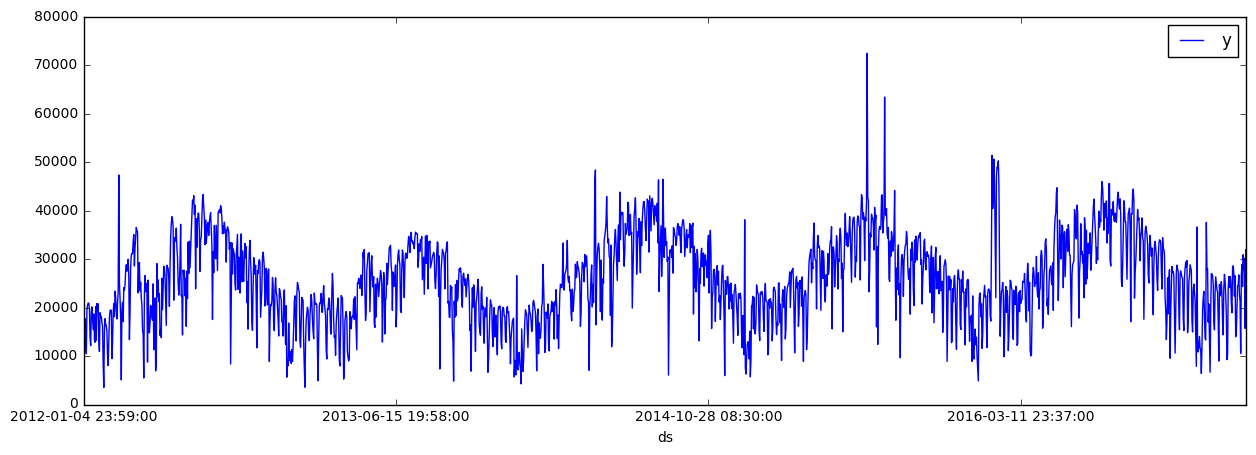

In [82]:
big_frame.plot(figsize=(15,5))

In [83]:
# Split into test and training
fb_train = big_frame[:len(big_frame)-PRED_PERIODS]
fb_test = big_frame[len(big_frame)-PRED_PERIODS:]

1772


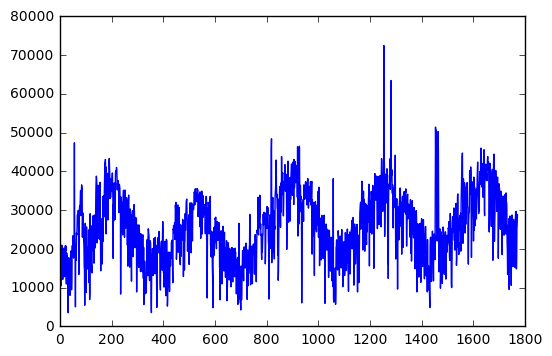

In [84]:
print(len(fb_train))
plt.plot(fb_train.y.values)

90


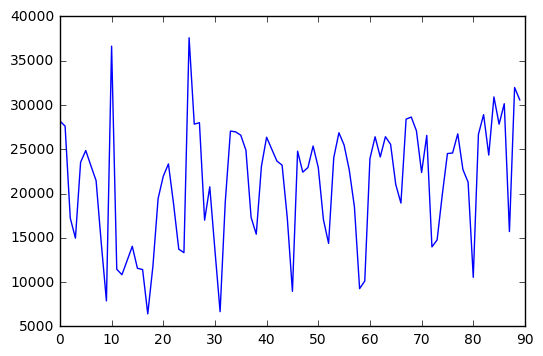

In [85]:
print(len(fb_test))
plt.plot(fb_test.y.values)

## Method 1 - Prophet

In [86]:
m = Prophet()
m.fit(fb_train)

In [87]:
future = m.make_future_dataframe(periods=PRED_PERIODS)
forecast = m.predict(future)

In [88]:
plot_guess = forecast[-PRED_PERIODS:]['yhat'].values
plot_truth = fb_test['y'].values

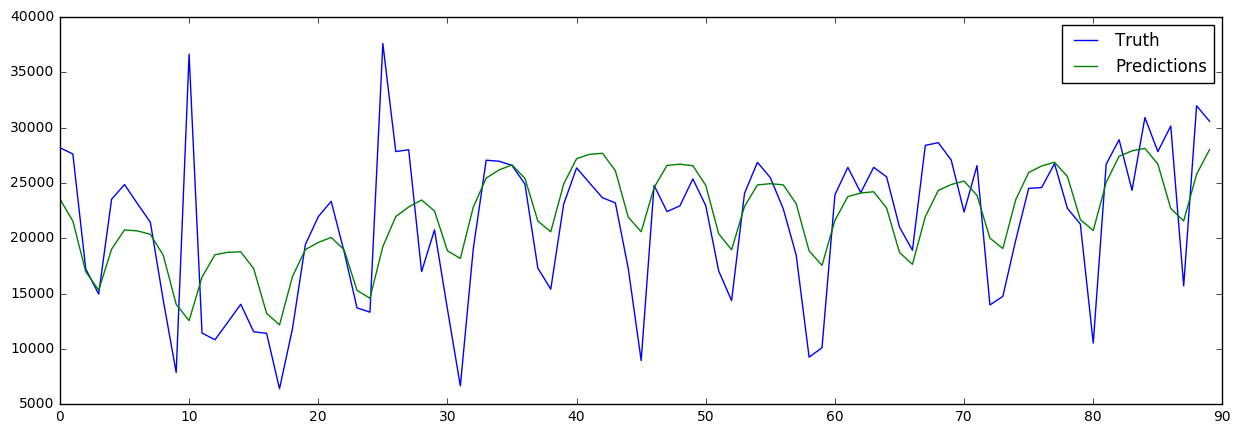

In [89]:
plot_results(plot_guess, plot_truth)

In [90]:
# Mean-Squared Error
sum((plot_guess-plot_truth)**2)/len(plot_guess)

28443295.177282911

## Method 2 - LSTM (predict based on prev prediction; one-by-one)

1772


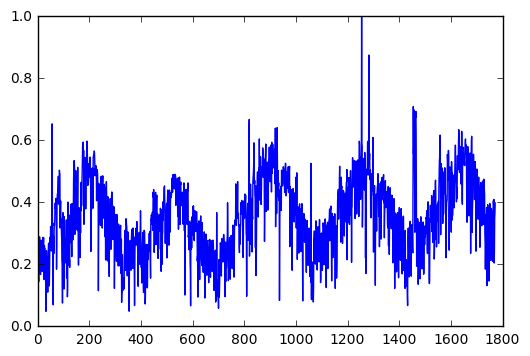

In [91]:
data = fb_train.y.values

# Scale to 0-1 range
scaled_by = max(data)
data = data/scaled_by

print(len(data))
plt.plot(data)

In [92]:
def load_data(data, seq_len):
    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    result = np.array(result)
    x_train = result[:, :-1]
    y_train = result[:, -1]
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    return [x_train, y_train]

In [93]:
def build_model(layers):
    model = Sequential()
    
    model.add(LSTM(
        input_shape=(None, layers[0]),
        units=layers[1],
        return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(
        units=layers[2],
        return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(units=layers[-1]))
    model.add(Activation("linear"))

    start = time.time()
    optimizer = RMSprop()
    model.compile(loss='mse', optimizer=optimizer)
    print("> Compilation Time : ", time.time() - start)
    return model

1671


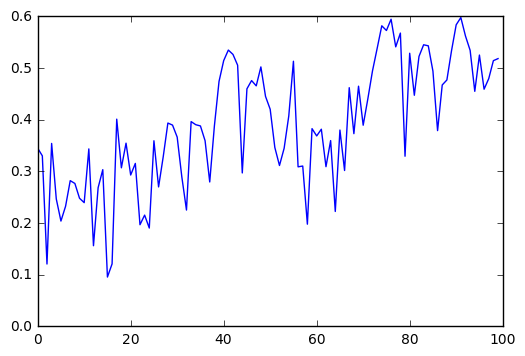

In [94]:
# Window-span
seq_len = 100
X_train, y_train = load_data(data, seq_len)
print(len(X_train))
plt.plot(y_train[:seq_len])

In [95]:
print(X_train.shape)
print(y_train.shape)

(1671, 100, 1)
(1671,)


In [96]:
model = build_model([1, 50, 100, 1])

model.fit(
    X_train,
    y_train,
    batch_size=400,
    epochs=3,
    validation_split=0.05)

> Compilation Time :  0.017011404037475586
Train on 1587 samples, validate on 84 samples
Epoch 1/3
1587/1587 [==============================] - 3s - loss: 0.0555 - val_loss: 0.0110
Epoch 2/3
1587/1587 [==============================] - 3s - loss: 0.0202 - val_loss: 0.0070
Epoch 3/3
1587/1587 [==============================] - 3s - loss: 0.0089 - val_loss: 0.0067


In [97]:
def make_forward_predictions(model, X_input, pred_for, seq_len):
    predictions = np.zeros(pred_for)
    for i in range(pred_for):
        pred_rs = X_input.reshape(1, X_input.shape[0], 1)
        pred = model.predict(pred_rs)
        predictions[i] = pred[0][0]
        X_input = np.concatenate((X_input[1:seq_len], pred))
    return predictions

In [98]:
%%time
# Take last X-value to init
X_train_in = X_train[-1]
predicted = make_forward_predictions(model, X_train_in, PRED_PERIODS, seq_len) * scaled_by

CPU times: user 5.38 s, sys: 3.85 s, total: 9.23 s
Wall time: 2.36 s


In [99]:
print(predicted[:10])

[ 25534.951695    25471.99585631  25448.91032019  25462.58575618
  25505.44006523  25569.45035371  25647.69571444  25734.85636178
  25827.01484185  25921.50910109]


In [100]:
print(plot_truth[:10])

[28191 27618 17237 14969 23535 24862 23135 21461 14409  7889]


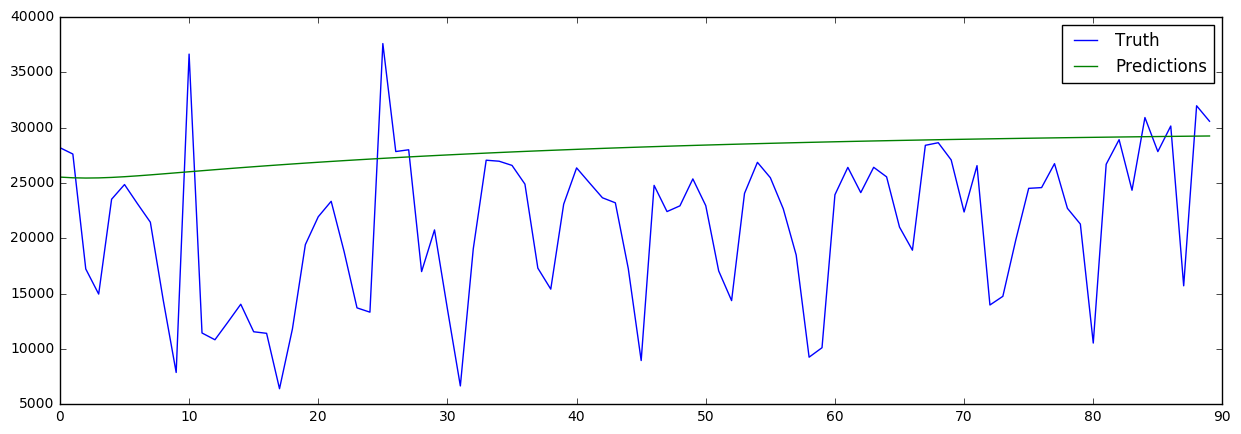

In [101]:
plot_results(predicted, plot_truth)

In [102]:
sum((predicted-plot_truth)**2)/len(predicted)

87340021.80172278

## Method 3 - LSTM (predict in one go)

In [103]:
def load_data_mult(data, seq_len, pred_forward):
    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length - pred_forward):
        result.append(data[index: index + sequence_length + pred_forward])
    result = np.array(result)
    x_train = result[:, :-pred_forward-1]
    y_train = result[:, -pred_forward-1:-1]
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    return [x_train, y_train]

In [104]:
X_train, y_train = load_data_mult(data, seq_len, PRED_PERIODS)

In [105]:
print(X_train.shape)
print(y_train.shape)

(1581, 100, 1)
(1581, 90)


In [106]:
model = build_model([1, 50, 150, y_train.shape[-1]])

model.fit(
    X_train,
    y_train,
    batch_size=400,
    epochs=3,
    validation_split=0.05)

> Compilation Time :  0.01702713966369629
Train on 1501 samples, validate on 80 samples
Epoch 1/3
1501/1501 [==============================] - 4s - loss: 0.1704 - val_loss: 0.1264
Epoch 2/3
1501/1501 [==============================] - 4s - loss: 0.0579 - val_loss: 0.0303
Epoch 3/3
1501/1501 [==============================] - 4s - loss: 0.0347 - val_loss: 0.0174


In [107]:
%%time
X_train_in = X_train[-1]
predicted = model.predict(X_train_in.reshape(1, X_train_in.shape[0], 1))[0] * scaled_by

CPU times: user 465 ms, sys: 55.8 ms, total: 521 ms
Wall time: 440 ms


In [108]:
print(predicted[:10])

[ 30632.47100049  29420.74612728  31763.64714518  32918.22213587
  23109.69987658  30740.5650692   30645.26052579  19204.45646352
  31538.96074742  26090.95140469]


In [109]:
print(plot_truth[:10])

[28191 27618 17237 14969 23535 24862 23135 21461 14409  7889]


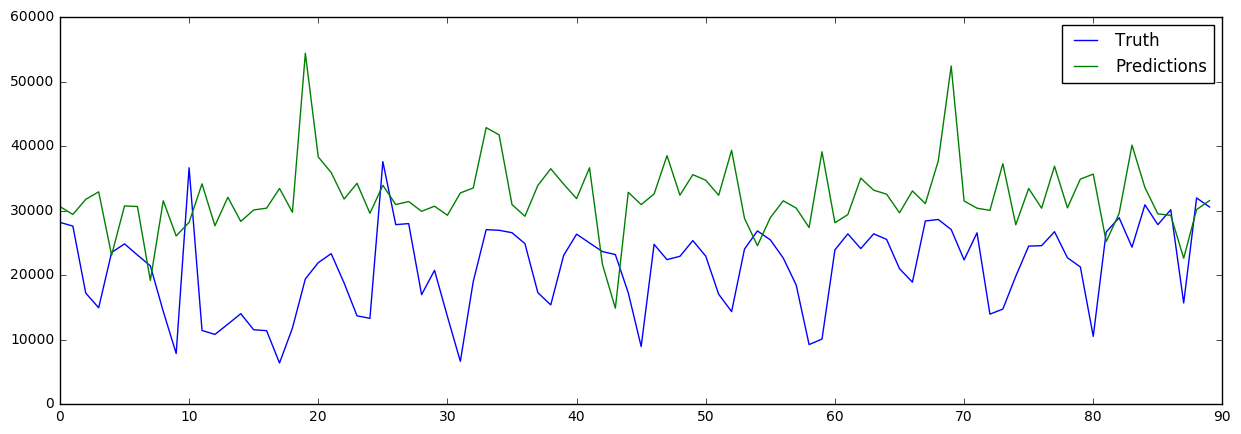

In [110]:
plot_results(predicted, plot_truth)

In [111]:
sum((predicted-plot_truth)**2)/len(predicted)

191605218.34640324